In [2]:
%matplotlib inline

In [3]:
%%capture
!pip install gym[atari]==0.25

!pip install torch
!pip install torchvision

## Display requirements

In [4]:
!pip install pyglet==1.5.0

In [5]:
!pip install pyvirtualdisplay

In [6]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb

In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import os
from pyvirtualdisplay import Display
from matplotlib import animation, rc

In [13]:
display = Display(visible = 0, size = (1400, 900))
display.start()

os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)

env = gym.make('CartPole-v1', new_step_api = True, render_mode = "rgb_array")

is_python = 'inline' in matplotlib.get_backend()
if is_python:
  from IPython import display
plt.ion()

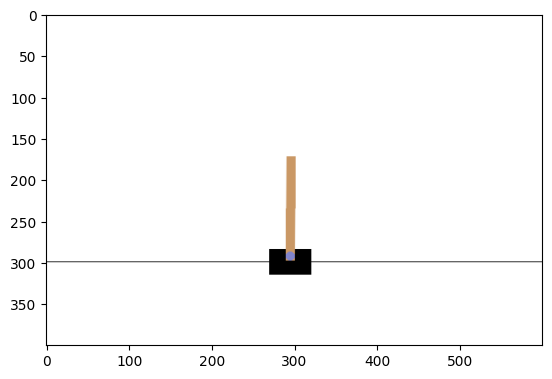

In [14]:
env.reset()
screen = env.render() #ENV.RENDER IS GIVING OUT A NDARRAY FOR THE CURRENT OBSERVATION OF THE ENVIRONMENT
plt.imshow(screen[0]) #pehle toh kaam hi nahi kar raha tha
plt.grid(False)

Game terminated after: 19  with reward =  19.0


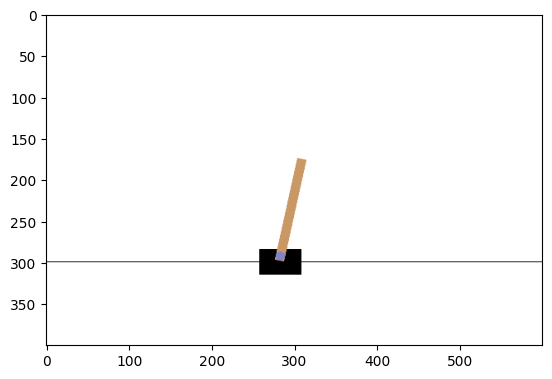

In [15]:
frame = []
env.reset()
total_reward = 0

for i in range(100):
  action = env.action_space.sample()
  new_state, reward, truncated, terminated, info = env.step(action)
  total_reward += reward
  screen = env.render()[0]
  img = plt.imshow(screen)
  frame.append([img])
  if truncated or terminated:
    break

print("Game terminated after:", len(frame), " with reward = ", total_reward)
# len(frame),

In [16]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [17]:
class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = deque([], maxlen = self.capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [18]:
class DQN(nn.Module):

  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size=5, stride = 2)
    self.bn3 = nn.BatchNorm2d(32)

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size - 1) - 1)//stride + 1

    conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
    conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

    linear_input_size = conv_w*conv_h*32

    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))

    return self.head(x.view(x.size(0), -1))


In [ ]:
resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation = Image.CUBIC), T.ToTensor()])

def get_cart_location(screen_width):
  world_width = env.x_threshold*2
  scale = screen_width/world_width
  return int(env.state[0]*scale + screen_width/2.0)

def get_screen():
  screen = env.render()[0]
  screen = screen.transpose((2, 0, 1)) #Why should I render the environment?
  _, screen_height, screen_width = screen.shape
  screen = screen[:, int(screen_height*0.4) : int(screen_height*0.8)]

  view_width = int(screen_width * 0.6)

  cart_location = get_cart_location(view_width)

  if cart_location < view_width//2:
    slice_range = slice(view_width)
  elif cart_location > (screen_width - view_width)//2:
    slice_range = slice(-view_width, None)
  else:
    slice_range = slice(cart_location - view_width//2, cart_location + view_width//2)

  screen = screen[:, :, slice_range]
  screen = np.ascontiguousarray(screen, dtype = np.float32)/255
  screen = torch.from_numpy(screen)

  return resize(screen).unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation = 'none')
plt.title('Example extracted screen')
plt.show()

In [20]:
BATCH_SIZE = 128
GAMMA = 0.995
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions)
target_net = DQN(screen_height, screen_width, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0
num_episodes = 25

IndexError: ignored

In [48]:
#Helper functions

def select_action(state, policy = None, train = None):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END)*math.exp(-1.*steps_done/EPS_DECAY)
  steps_done += 1

  with torch.no_grad():
    action = policy(state).max(1)[1].view(1,1)

  if train:
    if sample > eps_threshold:
      return action
    else:
      return torch.tensor([[random.randrange(n_actions)]], dtype = torch.long)

  else:
    return action

episode_duration = []

def plot_durations():
  plt.figure(2)
  plt.clf()
  duration_t = torch.tensor(episode_duration, dtype = torch.float)
  plt.title("Training...")
  plt.xlabel("Episode")
  plt.ylabel("Duration")
  plt.plot(duration_t.numpy())

  if len(duration_t) >= 100:
    means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())

  plt.pause(0.001)
  if is_python:
    display.clear_output(wait = True)
    display.display(plt.gcf())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
def optim_model():
  if len(memory) < BATCH_SIZE: #FIRST INSTANCE MEIN YEH NONE OBJECT RETURN KAR RAHA HAI
    return #HOW TO OVERCOME THIS?

  transitions = memory.sample(BATCH_SIZE)
  batch = Transition(*zip(*transitions))

  non_final_mask= torch.tensor(tuple(map(lambda s : s is not None, batch.next_state)), dtype = torch.bool)

  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)

  next_state_values = torch.zeros(BATCH_SIZE)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

  expected_state_action_values = (next_state_values*GAMMA) + reward_batch

  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()

  for param in policy_net.parameters():
    print(param)
    param.grad.data.clamp(-1, 1)
  optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
from tqdm import tqdm

In [ ]:
from IPython.core import prefilter

for i in tqdm(range(num_episodes + 1)):
  env.reset()
  last_screen = get_screen()
  current_screen = get_screen()
  state = current_screen - last_screen

  for t in count():
    # action = select_action(state, policy_net, train = False)
    action = select_action(state, policy_net)
    _, reward, truncated, terminated, _ = env.step(action.item())
    reward = torch.tensor([reward])

    last_screen = current_screen
    current_screen = get_screen()

    if not (truncated or terminated):
      next_state = current_screen - last_screen

    else:
      next_state = None

    memory.push(state, action, next_state, reward)

    state = next_state

    optim_model()
    if truncated or terminated:
      episode_duration.append(t + 1)
      break

  if i % TARGET_UPDATE == 0:
    print(f"Completed episodes: {i}")
    target_net.load_state_dict(policy_net.state_dict())

  if i % 50 == 0:
    print(f"Playing games after episode: {i}")
    frame = []
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()

    state = current_screen - last_screen
    total_reward = 0
    for i in range(1000):
      if i == 0:
        action = env.action_space.sample()

      action = select_action(state, policy_net, train = False)
      pseudo_state, reward, truncated, terminated, info = env.step(action)
      total_reward += reward

      last_screen = current_screen
      current_screen = get_screen()

      if not (truncated or terminated):
        state = current_screen - last_screen
      else:
        break

      if truncated or terminated:
        break

    print(f"Game terminated after: {len(frame)}, steps with reward {total_reward}")

print("Complete")
env.render()
env.close()
plt.ioff()
plt.show()

In [104]:
sum_reward = 0
frame = []

for j in range(1):
  last_screen = get_screen()
  current_screen = get_screen()

  state = current_screen - last_screen
  STEPS = 0
  total_reward = 0

  for i in range(300):

    if i == 0:
      action = env.action_space.sample()

    action = select_action(state, policy_net, train = False) #action is discrete with a value 2

    print("Action state is: ", action[0][0])
    pseudo_state, reward, truncated, terminated, info = env.step(action[0][0]) #Why is reward = 1, at each step?? IT IS DEFINED THIS WAY, I HAVE TO KEEP IT UPRIGHT FOR EVERY STEP, I'LL GET A REWARD
                                                        #ENV.STEP IS RENDERING THE ENVIRONMENT, GIVING OUT AN EMPTY LIST BELOW
    print("The reward is: ", reward)
    total_reward += reward
    print("Total reward is:", total_reward)

    last_screen = current_screen
    current_screen = get_screen()

    STEPS += 1

    if not truncated or terminated:
      state = current_screen - last_screen
    # if not :
    #   state = current_screen - last_screen
    else:
      break

    img = plt.imshow(env.render()[0]) #WHEN STEP IS TAKEN IT AUTOMATICALLY RENDERS THE ENVIRONMENT, PSEUDO_STATE ??
    frame.append([img])

    if truncated or terminated:
      break

  print(f"Game {j} terminated after {STEPS} steps with reward {total_reward}")
  # print(f"Game {j} terminated after {len(frame)} steps with reward {total_reward}")
  sum_reward += total_reward

print("Average reward", sum_reward/100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: ignored

In [ ]:
fig = plt.figure()

anim = animation.ArtistAnimation(fig, frame, interval = 100, repeat_delay = 1000, blit = True)

rc('animation', html = 'jshtml')
anim